In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional
import pandas as pd
from torchsummary import summary
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import chi2_contingency


### Audiorecordings(from lectures)

dict_keys(['speaker_embedding', 'specgram', 'melfilterbank', 'mfcc', 'sample_rate', 'opensmile'])


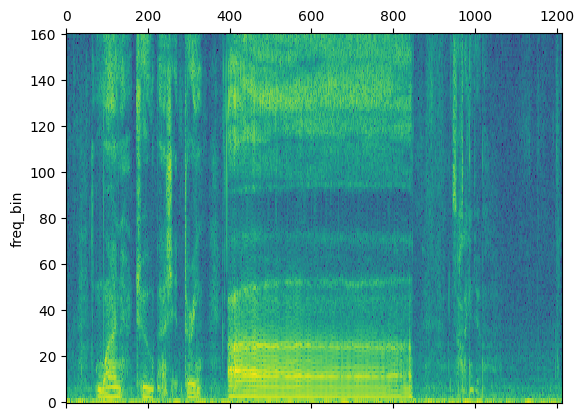

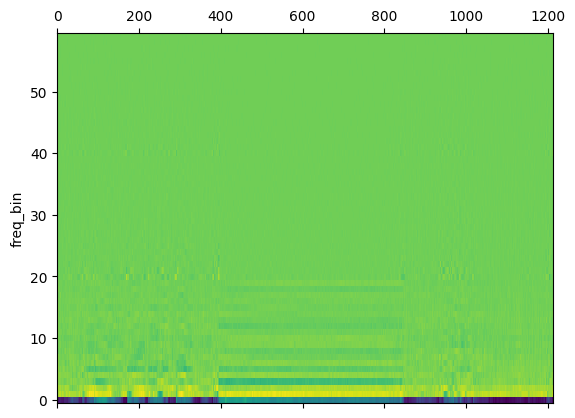

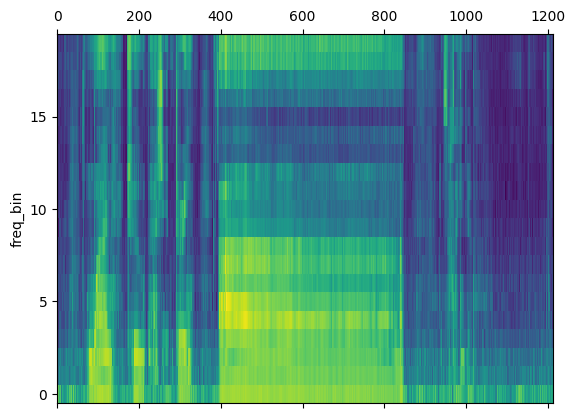

In [52]:
dataset = VBAIDataset('../bids_with_sensitive_recordings')
path = '../bids_with_sensitive_recordings/sub-9c6e4508-5a33-4e3c-9058-b21503c5966e/ses-291F92AC-4B67-4A6E-9AE2-6ACB15772371/audio/sub-9c6e4508-5a33-4e3c-9058-b21503c5966e_ses-291F92AC-4B67-4A6E-9AE2-6ACB15772371_Prolonged-vowel_rec-Prolonged-vowel'
data = torch.load(path + '.pt')
melfilterbank = data["melfilterbank"]
print(data.keys())
mfcc = data["mfcc"]
pt_spec = data["specgram"]
audio = Audio.from_file(path + '.wav')
audio = audio.to_16khz()
win_length = 20
hop_length = 10
nfft = None
features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10))).T
pt_features_specgram = 10.0 * torch.log10(torch.maximum(pt_spec, torch.full(pt_spec.size(), fill_value=1e-10))).T
plot_spectrogram(features_specgram)
plot_spectrogram(mfcc.T)
plot_spectrogram(melfilterbank.T)

### Dataset / diagnosis extraction

In [53]:
# loading the dataset
dataset = VBAIDataset('../bids_with_sensitive_recordings/')

target_diagnosis = 'airway_stenosis' #airway_stenosis

In [54]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

In [55]:
qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].drop_duplicates(subset='recording_session_id')

person_session_pairs.reset_index(drop=True, inplace=True)

print('Found {} person/session pairs'.format(len(person_session_pairs)))

Found 204 person/session pairs


In [56]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
participant_df = participant_df[['record_id', target_diagnosis]]
participant_df.shape

(178, 2)

In [57]:
Train1 = pd.merge(person_session_pairs, participant_df, on='record_id', how='inner')
Train1.shape

(204, 3)

### Demographics

In [58]:
dg = pd.read_csv('../demographics.csv')
dg = dg[(pd.notna(dg['household_income_usa']) | pd.notna(dg['household_income_ca'])) &
                                   (~((dg['household_income_usa'] == 'Prefer not to answer') | 
                                      (dg['household_income_ca'] == 'Prefer not to answer')))]
pre_train_labeled = pd.DataFrame(dg[["record_id", "demographics_session_id"]])

for index, row in dg.iterrows():
    if pd.notna(dg.loc[index, "household_income_usa"]) and dg.loc[index, "household_count"] >= 3: # USD; HH >= 3
        income = dg.loc[index, "household_income_usa"]
        if income in ['< $15,000', '$15,000 to $29,999']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_usa")
    
    elif pd.notna(dg.loc[index, "household_income_usa"]): # USD; HH < 3
        income = dg.loc[index, "household_income_usa"]
        if income in ['< $15,000']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$15,000 to $29,999', '$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$100,000 to $149,999', '$150,000 to $199,999', '$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_usa")
        
    elif pd.notna(dg.loc[index, "household_income_ca"]):  # CA; HH >= 3
        income = dg.loc[index, "household_income_ca"]
        if income in ['< $15,000', '$15,000 to $29,999']:
            pre_train_labeled.at[index, "SES"] = 0
        elif income in ['$30,000 to $$49,999']:
            pre_train_labeled.at[index, "SES"] = 1
        elif income in ['$50,000 to $99,999', '$100,000 to $149,999']:
            pre_train_labeled.at[index, "SES"] = 2
        elif income in ['$150,000 to $199,999', '$200,000 to $249,999', '>$250,000']:
            pre_train_labeled.at[index, "SES"] = 3
        elif income in ['Prefer not to answer']:
            continue
        else:
            print(income)
            raise ValueError("Wrong value for household_income_ca")
    else:
        print(index)

In [59]:
Train = pd.merge(Train1, pre_train_labeled, on='record_id', how='left')
columns_to_fill = ['demographics_session_id', 'SES']
Train[columns_to_fill] = Train[columns_to_fill].fillna(-1)
columns_to_check = ["record_id", "recording_session_id"]
Train = Train.drop_duplicates(subset=columns_to_check, keep='first')
Train[(Train[target_diagnosis] == True) & (Train['SES'] == 2.0)]

,record_id,recording_session_id,airway_stenosis,demographics_session_id,SES
4,022c62b4-1b02-43f1-90cf-301b61eb406c,653DCE31-88E0-4937-A1E9-178C2E08D204,True,653DCE31-88E0-4937-A1E9-178C2E08D204,2.0
5,022c62b4-1b02-43f1-90cf-301b61eb406c,CFB7788D-0ED6-49A8-9935-D66C5A4EFDB2,True,653DCE31-88E0-4937-A1E9-178C2E08D204,2.0
12,149f5b8a-aa7e-4806-9025-606c9fac95a2,C81204E5-FF3D-465E-9B4D-06A769616048,True,C81204E5-FF3D-465E-9B4D-06A769616048,2.0
13,15943fd6-c8ba-48b7-a754-ab15a9781831,FAC15A71-AF37-496F-868A-D7927E8C89E6,True,FAC15A71-AF37-496F-868A-D7927E8C89E6,2.0
32,2c95136b-0efb-4d67-8fdf-113a8af5ac12,3596D51F-73B0-47AE-BFAB-08FE8A2B9295,True,3596D51F-73B0-47AE-BFAB-08FE8A2B9295,2.0
83,72bd9f6a-134f-4a4f-8e31-5ded9e52d25b,4ABBC3F3-A890-4549-96BD-DEC5D55CBB77,True,4ABBC3F3-A890-4549-96BD-DEC5D55CBB77,2.0
112,92aa646d-f022-4b91-802f-854e1cbd444f,C63E6402-5ECC-45B5-8A57-6FE638A766A5,True,C63E6402-5ECC-45B5-8A57-6FE638A766A5,2.0
116,9a657e0d-2416-4af8-bf88-5ad2e15f2641,FD7F03F1-04D2-4718-89D4-CDD1594C9B72,True,FD7F03F1-04D2-4718-89D4-CDD1594C9B72,2.0
127,a58d1e3f-dc63-4211-ab71-ad0a2797733c,9829C772-79B5-4BE0-AFB4-A6D8EE0DDB31,True,9829C772-79B5-4BE0-AFB4-A6D8EE0DDB31,2.0
134,b076f63b-b218-4549-a531-7c33652de45b,712358D9-5E5E-47E7-94EB-3EBBC580868D,True,712358D9-5E5E-47E7-94EB-3EBBC580868D,2.0


In [123]:
X = Train[['record_id', 'recording_session_id', 'SES']]
y = Train[[target_diagnosis]]

X_positive = X[y[target_diagnosis] == 1]
y_positive = y[y[target_diagnosis] == 1]
X_negative = X[y[target_diagnosis] == 0]
y_negative = y[y[target_diagnosis] == 0]

# 2. Split X_positive into X_positive_train, X_positive_val, X_positive_test with stratify
X_positive_train, X_positive_temp, y_positive_train, y_positive_temp = train_test_split(
    X_positive, y_positive, test_size=0.25, stratify=y_positive
)
X_positive_val, X_positive_test, y_positive_val, y_positive_test = train_test_split(
    X_positive_temp, y_positive_temp, test_size=0.5, stratify=y_positive_temp
)

# 3. Split X_negative into X_negative_train, X_negative_val, X_negative_test with stratify
X_negative_train, X_negative_temp, y_negative_train, y_negative_temp = train_test_split(
    X_negative, y_negative, test_size=0.25, stratify=y_negative
)
X_negative_val, X_negative_test, y_negative_val, y_negative_test = train_test_split(
    X_negative_temp, y_negative_temp, test_size=0.5, stratify=y_negative_temp
)

# 4. Merge all X_positives and X_negatives into X_train, X_val, X_test with y_train, y_val, y_test
X_train = pd.concat([X_positive_train, X_negative_train])
X_val = pd.concat([X_positive_val, X_negative_val])
X_test = pd.concat([X_positive_test, X_negative_test])

y_train = pd.concat([y_positive_train, y_negative_train])
y_val = pd.concat([y_positive_val, y_negative_val])
y_test = pd.concat([y_positive_test, y_negative_test])

print("train", y_train[target_diagnosis].value_counts())
print("validation", y_val[target_diagnosis].value_counts())
print("test", y_test[target_diagnosis].value_counts())

print("train", X_train['SES'].value_counts())
print("validation", X_val['SES'].value_counts())
print("test", X_test['SES'].value_counts())

train airway_stenosis
False    111
True      52
Name: count, dtype: int64
validation airway_stenosis
False    14
True      6
Name: count, dtype: int64
test airway_stenosis
False    14
True      7
Name: count, dtype: int64
train SES
-1.0    60
 1.0    34
 2.0    32
 3.0    25
 0.0    12
Name: count, dtype: int64
validation SES
 2.0    7
-1.0    5
 1.0    4
 3.0    2
 0.0    2
Name: count, dtype: int64
test SES
-1.0    7
 1.0    5
 3.0    4
 2.0    4
 0.0    1
Name: count, dtype: int64


### Dataset

In [61]:
# rainbow, story recall, Picture description
class RainbowMelfilterBankDatasetWithMultisampling(torch.utils.data.Dataset):
	def __init__(self, data, segment_size):
		self.segment_size = segment_size
		self.data = data
		self.data[target_diagnosis] = self.data[target_diagnosis].astype(float)
		self.data.reset_index(drop=True, inplace=True)
		
		# get location for every recording of rainbow passage // generate multiple samples per recording
		index = 0
		while index < len(self.data):
			row = self.data.iloc[index]
			if not pd.notna(row['record_id']):
				self.data = self.data.drop(index = index)
				self.data.reset_index(drop=True, inplace=True)
				# index += 1
				display("dropped", row)
				continue
			subject = "sub-" + row['record_id']
			session = "ses-" + row['recording_session_id']
			location = str("../bids_with_sensitive_recordings/" + subject + "/" + session + '/audio/'+subject+"_"+session+"_Rainbow-Passage_rec-Rainbow-Passage")
			if os.path.exists(location + '.wav'):
				self.data.at[index, "location"] = location
				self.data.at[index, "segment"] = 0
				audio = Audio.from_file(location+".wav")
				audio = audio.to_16khz().signal.squeeze()
				num_segments = audio.size(0) // 160 // self.segment_size #audio size mapping to spectrogram size
    			#insert num_segment rows with different segment number(each record is different timeframe of the same recording)
				count = 1
				while count < num_segments:
					row_to_copy = self.data.iloc[index]
					row_df = pd.DataFrame([row_to_copy])
					self.data = pd.concat([self.data.iloc[:index+1], row_df, self.data.iloc[index+1:]]).reset_index(drop=True)
					index += 1
					self.data.at[index, "segment"] = count
					count += 1

			else:
				# print all patients without Rainbow passage recording   
				print("Location does not exist ", location)
				data.at[index, "location"] = "DNE"
				self.data = self.data.drop(index = index)
				self.data.reset_index(drop=True, inplace=True)
				index-=1
			index += 1
		self.data.reset_index(drop=True, inplace=True)

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		if not os.path.exists(self.data.loc[idx, "location"]+'.pt'):
			display("error", self.data.loc[idx, "location"])
		torch_data = torch.load(self.data.loc[idx, "location"]+'.pt')
		melfilterbank = torch_data["melfilterbank"]
		
		seg_num = self.data.loc[idx, "segment"]
		max_seg_size = melfilterbank.size(0) // self.segment_size
  
		start = (melfilterbank.size(0) - self.segment_size * max_seg_size) // 2
		start = int(start + self.segment_size * seg_num)

		melfilterbank = melfilterbank[start:start+self.segment_size, :]

		label = self.data.loc[idx, target_diagnosis]
  
		ses = self.data.loc[idx, 'SES']
		
		return {'signal': melfilterbank.T, 'label': label, 'SES': ses}

In [122]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_dataset = RainbowMelfilterBankDatasetWithMultisampling(train_df, 400)
val_dataset = RainbowMelfilterBankDatasetWithMultisampling(val_df, 400)
test_dataset = RainbowMelfilterBankDatasetWithMultisampling(test_df, 400)

print("Train dataset counts: ")
print(train_dataset.data[target_diagnosis].value_counts())
print(train_dataset.data["SES"].value_counts())
print("Validation dataset counts: ")
print(val_dataset.data[target_diagnosis].value_counts())
print(val_dataset.data["SES"].value_counts())
print("Test dataset counts: ")
print(test_dataset.data[target_diagnosis].value_counts())
print(test_dataset.data["SES"].value_counts())

print("Perform data check:")
check_loc_1 = train_dataset.data[~train_dataset.data['location'].str.endswith('Rainbow-Passage')].empty
check_loc_2 = val_dataset.data[~val_dataset.data['location'].str.endswith('Rainbow-Passage')].empty
check_loc_3 = test_dataset.data[~test_dataset.data['location'].str.endswith('Rainbow-Passage')].empty
if ~check_loc_1 and ~check_loc_2 and ~check_loc_3:
    print("\tAll locations are not NaN")
else:
    print("\tFound incorrect locations")
    
check_dublicates_1 = train_dataset.data[train_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
check_dublicates_2 = val_dataset.data[val_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
check_dublicates_3 = test_dataset.data[test_dataset.data.duplicated(subset=['location', 'segment'], keep=False)].empty
if ~check_loc_1 and ~check_loc_2 and ~check_loc_3:
    print("\tNo dublicates were generated")
else:
    print("\tCheck dublicated values!")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=18, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=6, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=6, shuffle=False)

for batch in val_dataloader:
    print(batch['signal'].shape)
    break

Location does not exist  ../bids_with_sensitive_recordings/sub-f2f58f0a-4ffb-46b2-b95f-c4950ad82a83/ses-F31FCBD3-94CA-414C-8E84-85AC78796E27/audio/sub-f2f58f0a-4ffb-46b2-b95f-c4950ad82a83_ses-F31FCBD3-94CA-414C-8E84-85AC78796E27_Rainbow-Passage_rec-Rainbow-Passage
Location does not exist  ../bids_with_sensitive_recordings/sub-ecc63817-d3f5-4766-893c-d47b8382e96d/ses-B5AC76B1-4B75-41DA-87BD-6ADCE7704A30/audio/sub-ecc63817-d3f5-4766-893c-d47b8382e96d_ses-B5AC76B1-4B75-41DA-87BD-6ADCE7704A30_Rainbow-Passage_rec-Rainbow-Passage
Location does not exist  ../bids_with_sensitive_recordings/sub-5da3c0da-f5d0-45cb-a352-cacf58b5d9ef/ses-E8BCB84D-31CA-4942-AC6A-692EACB0FC34/audio/sub-5da3c0da-f5d0-45cb-a352-cacf58b5d9ef_ses-E8BCB84D-31CA-4942-AC6A-692EACB0FC34_Rainbow-Passage_rec-Rainbow-Passage
Location does not exist  ../bids_with_sensitive_recordings/sub-6980ce82-b88d-4c5b-b6a6-8ed166dc9eb3/ses-41D6EFF0-6CA2-44F5-BA2A-2A63A6BC1F3C/audio/sub-6980ce82-b88d-4c5b-b6a6-8ed166dc9eb3_ses-41D6EFF0-6CA2

In [108]:
train_class0_count = (y_train == 0).sum()
train_class1_count = (y_train == 1).sum()
class_counts = [train_class0_count, train_class1_count]
total_samples = sum(class_counts)
class_weights = [total_samples / (2 * count) for count in class_counts]
weights = torch.tensor(class_weights, dtype=torch.float32)
print(weights[0])
print(weights[1])
pos_weight = weights[1]/ weights[0]

tensor([0.7342])
tensor([1.5673])


### CNN Model

In [113]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Conv1d(20, 64, kernel_size=9, stride=3, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.mp = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Calculate the input size to the first linear layer
        self.fc_input_size = self._calculate_fc_input_size()
  
        self.fc1 = nn.Linear(self.fc_input_size, 64)
        self.fc3 = nn.Linear(64, 1)  # One output neuron for binary classification

    def forward(self, x):
        x = self.mp(self.bn1(torch.nn.functional.relu(self.conv1(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(x)  # Apply dropout before the linear layers
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc3(x)  # sigmoid applied in BCEWithLogitsLoss
        return x

    def _calculate_fc_input_size(self):
        x = torch.randn(1, 20, 400)
        x = self.mp(self.bn1(torch.nn.functional.relu(self.conv1(x))))
        return x.view(x.size(0), -1).size(1)

In [114]:
cnn = CNN_1D()
_ = summary(cnn, (20, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 132]          11,584
       BatchNorm1d-2              [-1, 64, 132]             128
         MaxPool1d-3               [-1, 64, 66]               0
           Dropout-4                 [-1, 4224]               0
            Linear-5                   [-1, 64]         270,400
            Linear-6                    [-1, 1]              65
Total params: 282,177
Trainable params: 282,177
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.19
Params size (MB): 1.08
Estimated Total Size (MB): 1.30
----------------------------------------------------------------


In [115]:
def eval(model, dataloader):
    model.eval()
    acc = 0
    total = 0
    
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    all_predictions = []
    all_ground_truths = []
    for batch in dataloader:
        with torch.no_grad():
            outputs = torch.sigmoid(model(batch['signal'])).squeeze()
            predicted = (outputs >= threshhold).float()
            ground_truth = batch['label']
            acc += (predicted == ground_truth).sum().item()
            total += ground_truth.size(0)
            
            true_positives += ((predicted == 1) & (ground_truth == 1)).sum().item()
            true_negatives += ((predicted == 0) & (ground_truth == 0)).sum().item()
            false_positives += ((predicted == 1) & (ground_truth == 0)).sum().item()
            false_negatives += ((predicted == 0) & (ground_truth == 1)).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy().flatten())
            all_ground_truths.extend(ground_truth.cpu().numpy().flatten())
            
    if true_positives + false_negatives > 0:
        accuracy_positive = true_positives / (true_positives + false_negatives)
    else:
        accuracy_positive = 0
    
    if true_negatives + false_positives > 0:
        accuracy_negative = true_negatives / (true_negatives + false_positives)
    else:
        accuracy_negative = 0
    
    average_accuracy = (accuracy_positive + accuracy_negative) / 2
    return average_accuracy, all_predictions, all_ground_truths

cnn = CNN_1D()
threshhold = 0.5
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

num_epochs = 15
best_val_acc = 0
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    cnn.train()
    closs = []
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = cnn(batch['signal']).squeeze()
        loss = criterion(outputs, batch['label'])
        closs += [loss.item()] * len(batch['signal'])
        loss.backward()
        optimizer.step()
    scheduler.step()
    train_loss = sum(closs) / len(closs)
    train_losses.append(train_loss)
    
    val_acc, _, _ = eval(cnn, val_dataloader)
    val_losses.append(train_loss)
    val_accuracies.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn.state_dict(), 'mymodel.pth')
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, Val Acc: {val_acc}')

Epoch 1/15, Loss: 0.8900533266184708, Val Acc: 0.6961722488038278
Epoch 2/15, Loss: 0.6887426957729359, Val Acc: 0.6907894736842105
Epoch 3/15, Loss: 0.6176363719723825, Val Acc: 0.56877990430622
Epoch 4/15, Loss: 0.5619966906978322, Val Acc: 0.722488038277512
Epoch 5/15, Loss: 0.5017682074801249, Val Acc: 0.6701555023923444
Epoch 6/15, Loss: 0.4624971299528963, Val Acc: 0.6794258373205742
Epoch 7/15, Loss: 0.45354319315820246, Val Acc: 0.6851076555023923
Epoch 8/15, Loss: 0.4297994336244692, Val Acc: 0.6833133971291866
Epoch 9/15, Loss: 0.4388885794583871, Val Acc: 0.6907894736842105
Epoch 10/15, Loss: 0.4373188370745261, Val Acc: 0.6889952153110048
Epoch 11/15, Loss: 0.42578856970812584, Val Acc: 0.6907894736842105
Epoch 12/15, Loss: 0.42079477059976317, Val Acc: 0.7021531100478469
Epoch 13/15, Loss: 0.40563873503202424, Val Acc: 0.6964712918660287
Epoch 14/15, Loss: 0.4337614755252577, Val Acc: 0.6889952153110048
Epoch 15/15, Loss: 0.426784205432084, Val Acc: 0.687200956937799


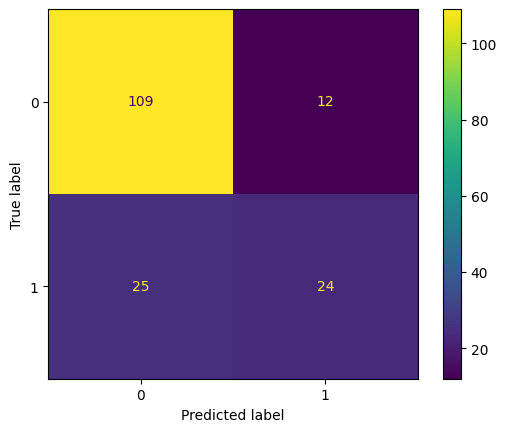

              precision    recall  f1-score   support

     Class 0       0.81      0.90      0.85       121
     Class 1       0.67      0.49      0.56        49

    accuracy                           0.78       170
   macro avg       0.74      0.70      0.71       170
weighted avg       0.77      0.78      0.77       170



In [116]:
_, predictions, ground_truths = eval(cnn, test_dataloader)
cm = confusion_matrix(ground_truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
report = classification_report(ground_truths, predictions, target_names=['Class 0', 'Class 1'])
print(report)

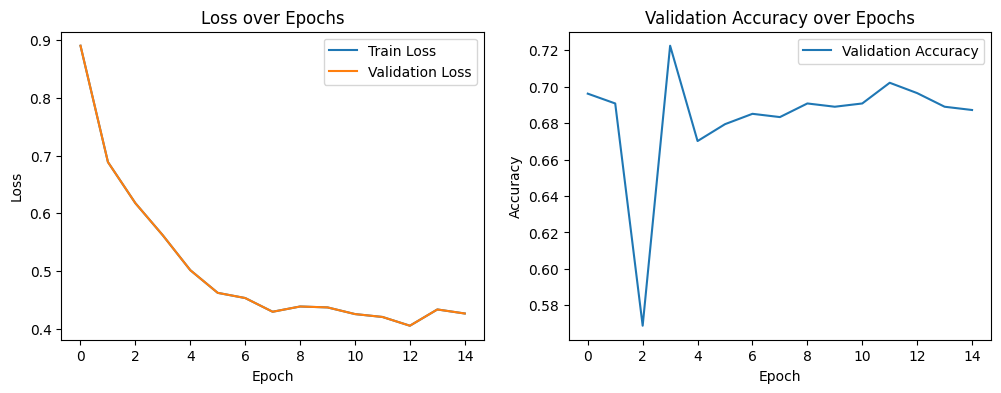

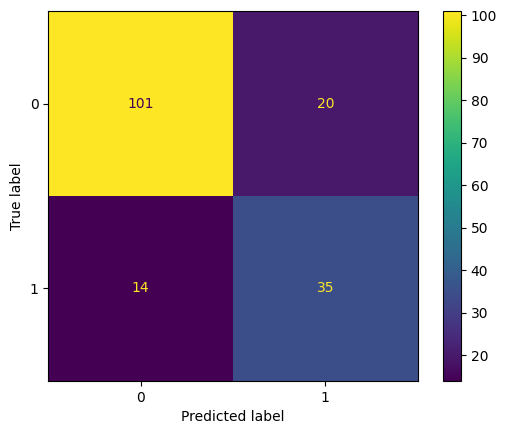

              precision    recall  f1-score   support

     Class 0       0.88      0.83      0.86       121
     Class 1       0.64      0.71      0.67        49

    accuracy                           0.80       170
   macro avg       0.76      0.77      0.76       170
weighted avg       0.81      0.80      0.80       170



In [117]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy over Epochs')
plt.show()

# Confusion matrix
cnn.load_state_dict(torch.load('mymodel.pth'))
_, predictions, ground_truths = eval(cnn, test_dataloader)

cm = confusion_matrix(ground_truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
report = classification_report(ground_truths, predictions, target_names=['Class 0', 'Class 1'])
print(report)

In [118]:
def analyze_test_predictions(model, test_dataloader):
    model.eval()
    all_test_values = []
    all_predictions = []
    all_ses = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            inputs = batch['signal']
            labels = batch['label']
            ses = batch['SES']
            
            outputs = torch.sigmoid(model(inputs)).squeeze()
            predicted = (outputs >= threshhold).float()
            
            all_test_values.extend(labels.cpu().numpy().flatten())
            all_predictions.extend(predicted.cpu().numpy().flatten())
            all_ses.extend(ses.cpu().numpy())
    
    # Create DataFrame
    df = pd.DataFrame({
        'Ses': all_ses,
        'test_value': all_test_values,
        'model_prediction': all_predictions
    })
    
    return df

df = analyze_test_predictions(cnn, test_dataloader)

In [119]:
df_undef = df[df['Ses'] == -1]
df_poverty = df[df['Ses'] == 0]
df_lower = df[df['Ses'] == 1]
df_middle = df[df['Ses'] == 2]
df_upper = df[df['Ses'] == 3]

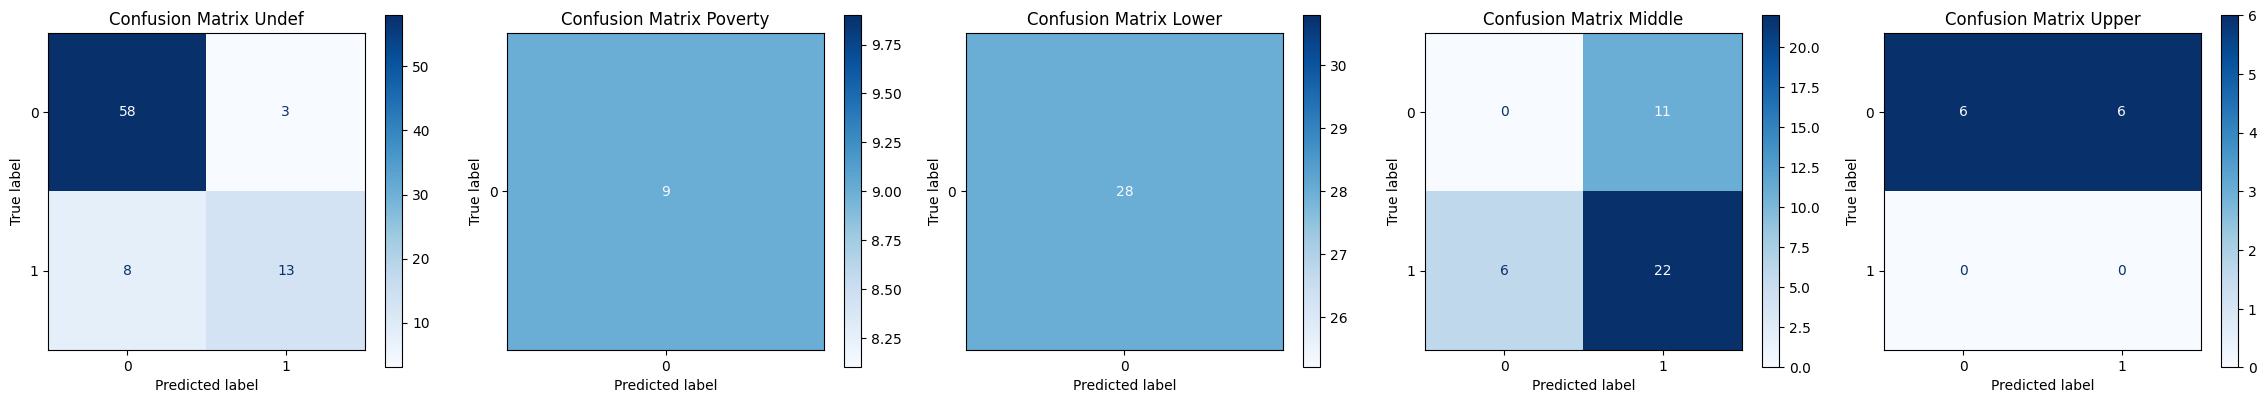

In [120]:
dataframes = [df_undef, df_poverty, df_lower, df_middle, df_upper]
titles = [
    'Confusion Matrix Undef',
    'Confusion Matrix Poverty',
    'Confusion Matrix Lower',
    'Confusion Matrix Middle',
    'Confusion Matrix Upper'
]

# Create subplots
fig, ax = plt.subplots(1, 5, figsize=(23, 4))

# Keep track of the index for the subplot
index = 0

for frame, title in zip(dataframes, titles):
    if not df.empty:  # Check if the dataframe is not empty
        cm = confusion_matrix(frame['test_value'], frame['model_prediction'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax[index], cmap='Blues')
        ax[index].title.set_text(title)
        index += 1

# Hide any remaining subplots
for i in range(index, len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

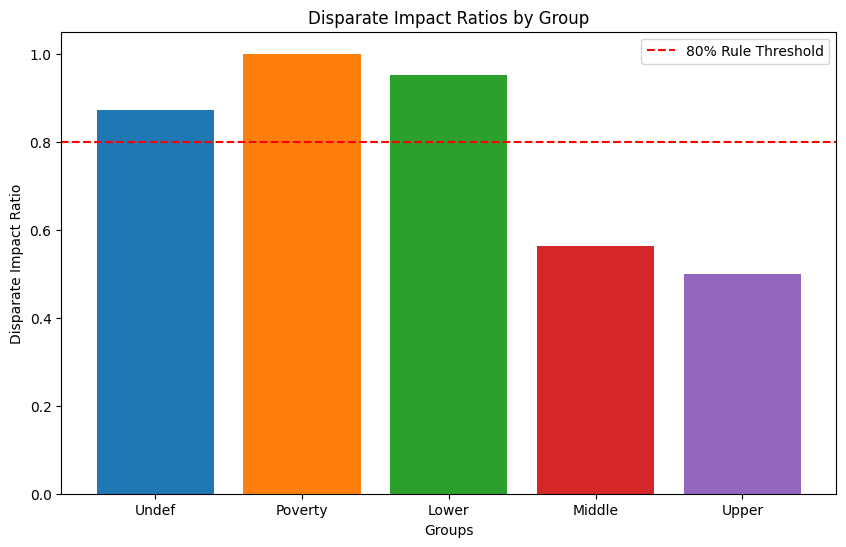

---SES---
Chi-Square Statistic: 57.336178675802984, p-value: 1.0517113769456995e-11
Disparate Impact Ratio for Group Undef: 0.873015873015873
Disparate Impact Ratio for Group Poverty: 1.0
Disparate Impact Ratio for Group Lower: 0.9523809523809523
Disparate Impact Ratio for Group Middle: 0.5625
Disparate Impact Ratio for Group Upper: 0.5



In [106]:
def chi_DIR_plot(demographics, ground_truth, _predictions_, attribute='SES', calc_chi_square=True):
    
    #print("---" , attribute.upper(), "---")
    
    sensitive_attribute = demographics
        
    contingency_table = pd.crosstab(sensitive_attribute, _predictions_, rownames=[attribute], colnames=['Prediction'])
    
    # Compare distributions
    _print_string_ = f'---{attribute.upper()}---\n'
    if calc_chi_square:
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        chi_square_result = {
            "chi2_stat": chi2_stat,
            "p_value": p_value,
            "dof": dof,
            "expected": expected
        }
        #print(f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}')
        _print_string_ += f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}\n'

    unique_groups = [-1.0, 0.0, 1.0, 2.0, 3.0]
    favorable_outcome = {}

    map_func = {
        '-1.0' : 'Undef',
        '0.0' : 'Poverty',
        '1.0' : 'Lower',
        '2.0' : 'Middle',
        '3.0' : 'Upper',
    }
        
    accuracies = [_predictions_ == ground_truth]
    for group in unique_groups:
        #group_predictions = _predictions_[sensitive_attribute == group]
        group_predictions = accuracies[0][sensitive_attribute == group]
        group_truth = ground_truth[sensitive_attribute == group]
        
        favorable_outcome[group] = np.mean(group_predictions)
        
    most_favorable_group = max(favorable_outcome, key=favorable_outcome.get)
    disparate_impact_ratios = {group: favorable_outcome[group] / favorable_outcome[most_favorable_group] for group in unique_groups}
    
    #Print the disparate impact ratios
    for group, ratio in disparate_impact_ratios.items():
        _print_string_ += f'Disparate Impact Ratio for Group {map_func[str(group)]}: {ratio}\n'
        #print(f'Disparate Impact Ratio for Group {map_func(group)}: {ratio}')

    # Plotting the disparate impact ratios
    plt.figure(figsize=(10, 6))
    groups = [map_func[str(group)] for group in unique_groups]
    ratios = [disparate_impact_ratios[group] for group in unique_groups]
    plt.bar(groups, ratios, color=plt.get_cmap('tab10').colors[:len(unique_groups)])
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Rule Threshold')
    plt.xlabel('Groups')
    plt.ylabel('Disparate Impact Ratio')
    plt.title('Disparate Impact Ratios by Group')
    plt.legend()
    plt.show()

    return chi_square_result, disparate_impact_ratios, _print_string_

_, _ , print_str = chi_DIR_plot(df['Ses'], df['test_value'], df['model_prediction'])
print(print_str)
